# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (BPW) most highly correlated with Consumption growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, BPW (<=2007, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'                     # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11834
EM converged at iteration 58, llf=-11595, convergence criterion=9.6944e-07 < tolerance=1e-06
EM start iterations, llf=-11847
EM converged at iteration 58, llf=-11607, convergence criterion=9.6844e-07 < tolerance=1e-06
EM start iterations, llf=-11898
EM converged at iteration 58, llf=-11657, convergence criterion=9.655e-07 < tolerance=1e-06
EM start iterations, llf=-11905
EM converged at iteration 58, llf=-11664, convergence criterion=9.6531e-07 < tolerance=1e-06
EM start iterations, llf=-11968
EM converged at iteration 58, llf=-11721, convergence criterion=9.746e-07 < tolerance=1e-06
EM start iterations, llf=-11976
EM converged at iteration 58, llf=-11728, convergence criterion=9.7184e-07 < tolerance=1e-06
EM start iterations, llf=-12031
EM converged at iteration 58, llf=-11784, convergence criterion=9.7666e-07 < tolerance=1e-06
EM start iterations, llf=-12031
EM converged at iteration 58, llf=-11784, convergence criterion=9.7666e-07 < tolerance=1e-06
EM

EM start iterations, llf=-13575
EM converged at iteration 59, llf=-13385, convergence criterion=9.9786e-07 < tolerance=1e-06
EM start iterations, llf=-13636
EM converged at iteration 58, llf=-13457, convergence criterion=9.7735e-07 < tolerance=1e-06
EM start iterations, llf=-13642
EM converged at iteration 58, llf=-13460, convergence criterion=9.7653e-07 < tolerance=1e-06
EM start iterations, llf=-13693
EM converged at iteration 58, llf=-13506, convergence criterion=9.7139e-07 < tolerance=1e-06
EM start iterations, llf=-13693
EM converged at iteration 58, llf=-13506, convergence criterion=9.7139e-07 < tolerance=1e-06
EM start iterations, llf=-13705
EM converged at iteration 58, llf=-13519, convergence criterion=9.7474e-07 < tolerance=1e-06
EM start iterations, llf=-13756
EM converged at iteration 58, llf=-13573, convergence criterion=9.8654e-07 < tolerance=1e-06
EM start iterations, llf=-13761
EM converged at iteration 58, llf=-13577, convergence criterion=9.8619e-07 < tolerance=1e-06


EM start iterations, llf=-15321
EM converged at iteration 52, llf=-15118, convergence criterion=9.8073e-07 < tolerance=1e-06
EM start iterations, llf=-15321
EM converged at iteration 52, llf=-15118, convergence criterion=9.8073e-07 < tolerance=1e-06
EM start iterations, llf=-15330
EM converged at iteration 52, llf=-15128, convergence criterion=9.8003e-07 < tolerance=1e-06
EM start iterations, llf=-15384
EM converged at iteration 52, llf=-15182, convergence criterion=9.7604e-07 < tolerance=1e-06
EM start iterations, llf=-15395
EM converged at iteration 52, llf=-15193, convergence criterion=9.7385e-07 < tolerance=1e-06
EM start iterations, llf=-15445
EM converged at iteration 52, llf=-15242, convergence criterion=9.7699e-07 < tolerance=1e-06
EM start iterations, llf=-15452
EM converged at iteration 52, llf=-15249, convergence criterion=9.7531e-07 < tolerance=1e-06
EM start iterations, llf=-15499
EM converged at iteration 52, llf=-15295, convergence criterion=9.7109e-07 < tolerance=1e-06


EM start iterations, llf=-17037
EM converged at iteration 62, llf=-16800, convergence criterion=9.744e-07 < tolerance=1e-06
EM start iterations, llf=-17041
EM converged at iteration 62, llf=-16805, convergence criterion=9.7425e-07 < tolerance=1e-06
EM start iterations, llf=-17096
EM converged at iteration 63, llf=-16860, convergence criterion=9.7069e-07 < tolerance=1e-06
EM start iterations, llf=-17102
EM converged at iteration 63, llf=-16866, convergence criterion=9.7086e-07 < tolerance=1e-06
EM start iterations, llf=-17157
EM converged at iteration 63, llf=-16921, convergence criterion=9.7578e-07 < tolerance=1e-06
EM start iterations, llf=-17157
EM converged at iteration 63, llf=-16921, convergence criterion=9.7578e-07 < tolerance=1e-06
EM start iterations, llf=-17166
EM converged at iteration 63, llf=-16931, convergence criterion=9.7423e-07 < tolerance=1e-06
EM start iterations, llf=-17220
EM converged at iteration 62, llf=-16984, convergence criterion=9.9603e-07 < tolerance=1e-06
E

EM start iterations, llf=-18570
EM converged at iteration 61, llf=-18322, convergence criterion=9.8579e-07 < tolerance=1e-06
EM start iterations, llf=-18631
EM converged at iteration 62, llf=-18381, convergence criterion=9.7717e-07 < tolerance=1e-06
EM start iterations, llf=-18631
EM converged at iteration 62, llf=-18381, convergence criterion=9.7717e-07 < tolerance=1e-06
EM start iterations, llf=-18636
EM converged at iteration 62, llf=-18386, convergence criterion=9.7703e-07 < tolerance=1e-06
EM start iterations, llf=-18688
EM converged at iteration 62, llf=-18437, convergence criterion=9.7672e-07 < tolerance=1e-06
EM start iterations, llf=-18695
EM converged at iteration 62, llf=-18444, convergence criterion=9.7618e-07 < tolerance=1e-06
EM start iterations, llf=-18754
EM converged at iteration 62, llf=-18501, convergence criterion=9.7474e-07 < tolerance=1e-06
EM start iterations, llf=-18761
EM converged at iteration 62, llf=-18508, convergence criterion=9.7452e-07 < tolerance=1e-06


EM converged at iteration 65, llf=-12115, convergence criterion=9.8432e-07 < tolerance=1e-06
EM start iterations, llf=-12359
EM converged at iteration 65, llf=-12095, convergence criterion=9.9195e-07 < tolerance=1e-06
EM start iterations, llf=-12424
EM converged at iteration 67, llf=-12173, convergence criterion=9.8814e-07 < tolerance=1e-06
EM start iterations, llf=-12443
EM converged at iteration 66, llf=-12198, convergence criterion=9.916e-07 < tolerance=1e-06
EM start iterations, llf=-12505
EM converged at iteration 69, llf=-12281, convergence criterion=9.838e-07 < tolerance=1e-06
EM start iterations, llf=-12504
EM converged at iteration 69, llf=-12278, convergence criterion=9.7781e-07 < tolerance=1e-06
EM start iterations, llf=-12526
EM converged at iteration 65, llf=-12307, convergence criterion=9.8239e-07 < tolerance=1e-06
EM start iterations, llf=-12526
EM converged at iteration 65, llf=-12307, convergence criterion=9.8239e-07 < tolerance=1e-06
EM start iterations, llf=-12533
EM

EM start iterations, llf=-14123
EM converged at iteration 57, llf=-13925, convergence criterion=9.6223e-07 < tolerance=1e-06
EM start iterations, llf=-14162
EM converged at iteration 56, llf=-13955, convergence criterion=9.5953e-07 < tolerance=1e-06
EM start iterations, llf=-14168
EM converged at iteration 56, llf=-13967, convergence criterion=9.9111e-07 < tolerance=1e-06
EM start iterations, llf=-14219
EM converged at iteration 59, llf=-14026, convergence criterion=9.9247e-07 < tolerance=1e-06
EM start iterations, llf=-14219
EM converged at iteration 59, llf=-14026, convergence criterion=9.9247e-07 < tolerance=1e-06
EM start iterations, llf=-14230
EM converged at iteration 59, llf=-14038, convergence criterion=9.954e-07 < tolerance=1e-06
EM start iterations, llf=-14283
EM converged at iteration 59, llf=-14090, convergence criterion=9.7034e-07 < tolerance=1e-06
EM start iterations, llf=-14290
EM converged at iteration 58, llf=-14096, convergence criterion=9.9423e-07 < tolerance=1e-06
E

EM start iterations, llf=-15877
EM converged at iteration 60, llf=-15661, convergence criterion=9.7455e-07 < tolerance=1e-06
EM start iterations, llf=-15877
EM converged at iteration 60, llf=-15661, convergence criterion=9.7455e-07 < tolerance=1e-06
EM start iterations, llf=-15885
EM converged at iteration 59, llf=-15669, convergence criterion=9.9341e-07 < tolerance=1e-06
EM start iterations, llf=-15938
EM converged at iteration 59, llf=-15720, convergence criterion=9.9248e-07 < tolerance=1e-06
EM start iterations, llf=-15940
EM converged at iteration 59, llf=-15721, convergence criterion=9.9437e-07 < tolerance=1e-06
EM start iterations, llf=-15995
EM converged at iteration 60, llf=-15775, convergence criterion=9.8855e-07 < tolerance=1e-06
EM start iterations, llf=-15999
EM converged at iteration 60, llf=-15779, convergence criterion=9.8652e-07 < tolerance=1e-06
EM start iterations, llf=-16045
EM converged at iteration 60, llf=-15826, convergence criterion=9.9363e-07 < tolerance=1e-06


EM start iterations, llf=-17596
EM converged at iteration 66, llf=-17364, convergence criterion=9.7122e-07 < tolerance=1e-06
EM start iterations, llf=-17602
EM converged at iteration 66, llf=-17369, convergence criterion=9.7037e-07 < tolerance=1e-06
EM start iterations, llf=-17653
EM converged at iteration 65, llf=-17420, convergence criterion=9.9905e-07 < tolerance=1e-06
EM start iterations, llf=-17661
EM converged at iteration 65, llf=-17426, convergence criterion=9.9559e-07 < tolerance=1e-06
EM start iterations, llf=-17711
EM converged at iteration 65, llf=-17475, convergence criterion=9.8308e-07 < tolerance=1e-06
EM start iterations, llf=-17711
EM converged at iteration 65, llf=-17475, convergence criterion=9.8308e-07 < tolerance=1e-06
EM start iterations, llf=-17730
EM converged at iteration 65, llf=-17494, convergence criterion=9.8293e-07 < tolerance=1e-06
EM start iterations, llf=-17783
EM converged at iteration 65, llf=-17547, convergence criterion=9.8203e-07 < tolerance=1e-06


EM start iterations, llf=-19118
EM converged at iteration 65, llf=-18855, convergence criterion=9.9346e-07 < tolerance=1e-06
EM start iterations, llf=-19171
EM converged at iteration 65, llf=-18908, convergence criterion=9.9088e-07 < tolerance=1e-06
EM start iterations, llf=-19171
EM converged at iteration 65, llf=-18908, convergence criterion=9.9088e-07 < tolerance=1e-06
EM start iterations, llf=-19178
EM converged at iteration 65, llf=-18917, convergence criterion=9.9187e-07 < tolerance=1e-06
EM start iterations, llf=-19235
EM converged at iteration 66, llf=-18974, convergence criterion=9.7e-07 < tolerance=1e-06
EM start iterations, llf=-19243
EM converged at iteration 66, llf=-18982, convergence criterion=9.6902e-07 < tolerance=1e-06
EM start iterations, llf=-19297
EM converged at iteration 65, llf=-19035, convergence criterion=9.9116e-07 < tolerance=1e-06
EM start iterations, llf=-19306
EM converged at iteration 65, llf=-19043, convergence criterion=9.8978e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-12889
EM converged at iteration 67, llf=-12676, convergence criterion=9.8194e-07 < tolerance=1e-06
EM start iterations, llf=-12895
EM converged at iteration 67, llf=-12683, convergence criterion=9.8083e-07 < tolerance=1e-06
EM start iterations, llf=-12945
EM converged at iteration 66, llf=-12731, convergence criterion=9.9595e-07 < tolerance=1e-06
EM start iterations, llf=-12952
EM converged at iteration 66, llf=-12738, convergence criterion=9.9644e-07 < tolerance=1e-06
EM start iterations, llf=-12997
EM converged at iteration 63, llf=-12778, convergence criterion=9.9753e-07 < tolerance=1e-06
EM start iterations, llf=-13008
EM converged at iteration 63, llf=-12788, convergence criterion=9.9307e-07 < tolerance=1e-06
EM start iterations, llf=-13066
EM converged at iteration 64, llf=-12854, convergence criterion=9.8356e-07 < tolerance=1e-06
EM start iterations, llf=-13066
EM converged at iteration 64, llf=-12854, convergence criterion=9.8356e-07 < tolerance=1e-06


EM start iterations, llf=-14646
EM converged at iteration 65, llf=-14446, convergence criterion=9.9243e-07 < tolerance=1e-06
EM start iterations, llf=-14705
EM converged at iteration 65, llf=-14510, convergence criterion=9.9795e-07 < tolerance=1e-06
EM start iterations, llf=-14714
EM converged at iteration 65, llf=-14515, convergence criterion=9.8774e-07 < tolerance=1e-06
EM start iterations, llf=-14768
EM converged at iteration 65, llf=-14571, convergence criterion=9.9414e-07 < tolerance=1e-06
EM start iterations, llf=-14768
EM converged at iteration 65, llf=-14571, convergence criterion=9.9414e-07 < tolerance=1e-06
EM start iterations, llf=-14776
EM converged at iteration 65, llf=-14578, convergence criterion=9.8685e-07 < tolerance=1e-06
EM start iterations, llf=-14832
EM converged at iteration 65, llf=-14633, convergence criterion=9.7488e-07 < tolerance=1e-06
EM start iterations, llf=-14841
EM converged at iteration 64, llf=-14640, convergence criterion=9.9662e-07 < tolerance=1e-06


EM start iterations, llf=-16426
EM converged at iteration 62, llf=-16204, convergence criterion=9.8138e-07 < tolerance=1e-06
EM start iterations, llf=-16426
EM converged at iteration 62, llf=-16204, convergence criterion=9.8138e-07 < tolerance=1e-06
EM start iterations, llf=-16435
EM converged at iteration 62, llf=-16213, convergence criterion=9.7956e-07 < tolerance=1e-06
EM start iterations, llf=-16484
EM converged at iteration 61, llf=-16261, convergence criterion=9.7332e-07 < tolerance=1e-06
EM start iterations, llf=-16493
EM converged at iteration 61, llf=-16270, convergence criterion=9.7187e-07 < tolerance=1e-06
EM start iterations, llf=-16542
EM converged at iteration 60, llf=-16318, convergence criterion=9.8042e-07 < tolerance=1e-06
EM start iterations, llf=-16549
EM converged at iteration 60, llf=-16325, convergence criterion=9.7788e-07 < tolerance=1e-06
EM start iterations, llf=-16601
EM converged at iteration 59, llf=-16375, convergence criterion=9.9874e-07 < tolerance=1e-06


EM start iterations, llf=-18129
EM converged at iteration 65, llf=-17887, convergence criterion=9.9702e-07 < tolerance=1e-06
EM start iterations, llf=-18135
EM converged at iteration 65, llf=-17895, convergence criterion=9.9774e-07 < tolerance=1e-06
EM start iterations, llf=-18194
EM converged at iteration 66, llf=-17951, convergence criterion=9.8582e-07 < tolerance=1e-06
EM start iterations, llf=-18201
EM converged at iteration 66, llf=-17958, convergence criterion=9.8537e-07 < tolerance=1e-06
EM start iterations, llf=-18257
EM converged at iteration 66, llf=-18014, convergence criterion=9.9113e-07 < tolerance=1e-06
EM start iterations, llf=-18257
EM converged at iteration 66, llf=-18014, convergence criterion=9.9113e-07 < tolerance=1e-06
EM start iterations, llf=-18261
EM converged at iteration 66, llf=-18016, convergence criterion=9.8898e-07 < tolerance=1e-06
EM start iterations, llf=-18313
EM converged at iteration 66, llf=-18067, convergence criterion=9.8655e-07 < tolerance=1e-06


EM start iterations, llf=-19378
EM converged at iteration 66, llf=-19109, convergence criterion=9.7374e-07 < tolerance=1e-06
EM start iterations, llf=-19434
EM converged at iteration 65, llf=-19165, convergence criterion=9.8947e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 2:25:14.408611.
EM start iterations, llf=-11358
EM converged at iteration 55, llf=-11219, convergence criterion=9.9036e-07 < tolerance=1e-06
EM start iterations, llf=-11371
EM converged at iteration 55, llf=-11232, convergence criterion=9.8997e-07 < tolerance=1e-06
EM start iterations, llf=-11422
EM converged at iteration 55, llf=-11283, convergence criterion=9.7571e-07 < tolerance=1e-06
EM start iterations, llf=-11429
EM converged at iteration 55, llf=-11290, convergence criterion=9.736e-07 < tolerance=1e-06
EM start iterations, llf=-11485
EM converged at iteration 53, llf=-11347, convergence criterion=9.9755e-07 < tolerance=1e-06
EM start iterations, llf=-11496
EM converged at 

EM start iterations, llf=-12863
EM converged at iteration 60, llf=-12721, convergence criterion=9.9901e-07 < tolerance=1e-06
EM start iterations, llf=-12876
EM converged at iteration 60, llf=-12733, convergence criterion=9.9964e-07 < tolerance=1e-06
EM start iterations, llf=-12909
EM converged at iteration 60, llf=-12765, convergence criterion=9.9802e-07 < tolerance=1e-06
EM start iterations, llf=-12916
EM converged at iteration 60, llf=-12770, convergence criterion=9.982e-07 < tolerance=1e-06
EM start iterations, llf=-12974
EM converged at iteration 59, llf=-12821, convergence criterion=9.8649e-07 < tolerance=1e-06
EM start iterations, llf=-12978
EM converged at iteration 59, llf=-12828, convergence criterion=9.863e-07 < tolerance=1e-06
EM start iterations, llf=-13019
EM converged at iteration 59, llf=-12869, convergence criterion=9.7341e-07 < tolerance=1e-06
EM start iterations, llf=-13019
EM converged at iteration 59, llf=-12869, convergence criterion=9.7341e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14484
EM converged at iteration 49, llf=-14326, convergence criterion=9.583e-07 < tolerance=1e-06
EM start iterations, llf=-14537
EM converged at iteration 50, llf=-14381, convergence criterion=9.8572e-07 < tolerance=1e-06
EM start iterations, llf=-14545
EM converged at iteration 50, llf=-14388, convergence criterion=9.8507e-07 < tolerance=1e-06
EM start iterations, llf=-14594
EM converged at iteration 50, llf=-14438, convergence criterion=9.8815e-07 < tolerance=1e-06
EM start iterations, llf=-14594
EM converged at iteration 50, llf=-14438, convergence criterion=9.8815e-07 < tolerance=1e-06
EM start iterations, llf=-14602
EM converged at iteration 50, llf=-14446, convergence criterion=9.8882e-07 < tolerance=1e-06
EM start iterations, llf=-14654
EM converged at iteration 50, llf=-14497, convergence criterion=9.8445e-07 < tolerance=1e-06
EM start iterations, llf=-14661
EM converged at iteration 50, llf=-14504, convergence criterion=9.8307e-07 < tolerance=1e-06
E

EM start iterations, llf=-16185
EM converged at iteration 61, llf=-16019, convergence criterion=9.8385e-07 < tolerance=1e-06
EM start iterations, llf=-16185
EM converged at iteration 61, llf=-16019, convergence criterion=9.8385e-07 < tolerance=1e-06
EM start iterations, llf=-16198
EM converged at iteration 61, llf=-16032, convergence criterion=9.8195e-07 < tolerance=1e-06
EM start iterations, llf=-16255
EM converged at iteration 61, llf=-16090, convergence criterion=9.866e-07 < tolerance=1e-06
EM start iterations, llf=-16257
EM converged at iteration 61, llf=-16093, convergence criterion=9.8885e-07 < tolerance=1e-06
EM start iterations, llf=-16311
EM converged at iteration 62, llf=-16146, convergence criterion=9.8277e-07 < tolerance=1e-06
EM start iterations, llf=-16317
EM converged at iteration 62, llf=-16153, convergence criterion=9.8214e-07 < tolerance=1e-06
EM start iterations, llf=-16368
EM converged at iteration 62, llf=-16204, convergence criterion=9.914e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17645
EM converged at iteration 62, llf=-17475, convergence criterion=9.7845e-07 < tolerance=1e-06
EM start iterations, llf=-17659
EM converged at iteration 62, llf=-17488, convergence criterion=9.7648e-07 < tolerance=1e-06
EM start iterations, llf=-17717
EM converged at iteration 61, llf=-17545, convergence criterion=9.7954e-07 < tolerance=1e-06
EM start iterations, llf=-17722
EM converged at iteration 61, llf=-17550, convergence criterion=9.7883e-07 < tolerance=1e-06
EM start iterations, llf=-17779
EM converged at iteration 61, llf=-17607, convergence criterion=9.9294e-07 < tolerance=1e-06
EM start iterations, llf=-17779
EM converged at iteration 61, llf=-17607, convergence criterion=9.9294e-07 < tolerance=1e-06
EM start iterations, llf=-17784
EM converged at iteration 61, llf=-17613, convergence criterion=9.9303e-07 < tolerance=1e-06
EM start iterations, llf=-17833
EM converged at iteration 61, llf=-17661, convergence criterion=9.9111e-07 < tolerance=1e-06


EM start iterations, llf=-11803
EM converged at iteration 73, llf=-11662, convergence criterion=9.9136e-07 < tolerance=1e-06
EM start iterations, llf=-11806
EM converged at iteration 72, llf=-11663, convergence criterion=9.9332e-07 < tolerance=1e-06
EM start iterations, llf=-11866
EM converged at iteration 67, llf=-11724, convergence criterion=9.9852e-07 < tolerance=1e-06
EM start iterations, llf=-11866
EM converged at iteration 67, llf=-11724, convergence criterion=9.9852e-07 < tolerance=1e-06
EM start iterations, llf=-11878
EM converged at iteration 69, llf=-11738, convergence criterion=9.904e-07 < tolerance=1e-06
EM start iterations, llf=-11955
EM converged at iteration 70, llf=-11821, convergence criterion=9.8795e-07 < tolerance=1e-06
EM start iterations, llf=-11941
EM converged at iteration 70, llf=-11807, convergence criterion=9.8936e-07 < tolerance=1e-06
EM start iterations, llf=-11959
EM converged at iteration 72, llf=-11816, convergence criterion=9.7648e-07 < tolerance=1e-06
E

EM start iterations, llf=-13367
EM converged at iteration 60, llf=-13213, convergence criterion=9.8829e-07 < tolerance=1e-06
EM start iterations, llf=-13376
EM converged at iteration 60, llf=-13223, convergence criterion=9.7595e-07 < tolerance=1e-06
EM start iterations, llf=-13423
EM converged at iteration 59, llf=-13270, convergence criterion=9.842e-07 < tolerance=1e-06
EM start iterations, llf=-13432
EM converged at iteration 59, llf=-13278, convergence criterion=9.8059e-07 < tolerance=1e-06
EM start iterations, llf=-13477
EM converged at iteration 59, llf=-13322, convergence criterion=9.7109e-07 < tolerance=1e-06
EM start iterations, llf=-13469
EM converged at iteration 59, llf=-13319, convergence criterion=9.6956e-07 < tolerance=1e-06
EM start iterations, llf=-13516
EM converged at iteration 60, llf=-13364, convergence criterion=9.9146e-07 < tolerance=1e-06
EM start iterations, llf=-13516
EM converged at iteration 60, llf=-13364, convergence criterion=9.9146e-07 < tolerance=1e-06
E

EM start iterations, llf=-15012
EM converged at iteration 58, llf=-14856, convergence criterion=9.8063e-07 < tolerance=1e-06
EM start iterations, llf=-15067
EM converged at iteration 56, llf=-14910, convergence criterion=9.8555e-07 < tolerance=1e-06
EM start iterations, llf=-15074
EM converged at iteration 56, llf=-14917, convergence criterion=9.886e-07 < tolerance=1e-06
EM start iterations, llf=-15120
EM converged at iteration 56, llf=-14965, convergence criterion=9.8949e-07 < tolerance=1e-06
EM start iterations, llf=-15120
EM converged at iteration 56, llf=-14965, convergence criterion=9.8949e-07 < tolerance=1e-06
EM start iterations, llf=-15133
EM converged at iteration 56, llf=-14977, convergence criterion=9.8694e-07 < tolerance=1e-06
EM start iterations, llf=-15188
EM converged at iteration 56, llf=-15030, convergence criterion=9.9128e-07 < tolerance=1e-06
EM start iterations, llf=-15187
EM converged at iteration 56, llf=-15031, convergence criterion=9.8526e-07 < tolerance=1e-06
E

EM start iterations, llf=-16716
EM converged at iteration 65, llf=-16547, convergence criterion=9.9098e-07 < tolerance=1e-06
EM start iterations, llf=-16716
EM converged at iteration 65, llf=-16547, convergence criterion=9.9098e-07 < tolerance=1e-06
EM start iterations, llf=-16725
EM converged at iteration 65, llf=-16555, convergence criterion=9.9253e-07 < tolerance=1e-06
EM start iterations, llf=-16773
EM converged at iteration 66, llf=-16603, convergence criterion=9.7914e-07 < tolerance=1e-06
EM start iterations, llf=-16778
EM converged at iteration 66, llf=-16608, convergence criterion=9.7911e-07 < tolerance=1e-06
EM start iterations, llf=-16829
EM converged at iteration 66, llf=-16659, convergence criterion=9.8259e-07 < tolerance=1e-06
EM start iterations, llf=-16838
EM converged at iteration 66, llf=-16669, convergence criterion=9.816e-07 < tolerance=1e-06
EM start iterations, llf=-16884
EM converged at iteration 66, llf=-16715, convergence criterion=9.7455e-07 < tolerance=1e-06
E

EM start iterations, llf=-18178
EM converged at iteration 66, llf=-18004, convergence criterion=9.748e-07 < tolerance=1e-06
EM start iterations, llf=-18185
EM converged at iteration 66, llf=-18011, convergence criterion=9.7333e-07 < tolerance=1e-06
EM start iterations, llf=-18234
EM converged at iteration 66, llf=-18060, convergence criterion=9.7447e-07 < tolerance=1e-06
EM start iterations, llf=-18241
EM converged at iteration 66, llf=-18066, convergence criterion=9.7078e-07 < tolerance=1e-06
EM start iterations, llf=-18289
EM converged at iteration 66, llf=-18114, convergence criterion=9.6955e-07 < tolerance=1e-06
EM start iterations, llf=-18289
EM converged at iteration 66, llf=-18114, convergence criterion=9.6955e-07 < tolerance=1e-06
EM start iterations, llf=-18294
EM converged at iteration 66, llf=-18119, convergence criterion=9.7128e-07 < tolerance=1e-06
EM start iterations, llf=-18350
EM converged at iteration 66, llf=-18174, convergence criterion=9.7827e-07 < tolerance=1e-06
E

EM start iterations, llf=-12241
EM converged at iteration 77, llf=-12093, convergence criterion=9.8001e-07 < tolerance=1e-06
EM start iterations, llf=-12257
EM converged at iteration 75, llf=-12105, convergence criterion=9.9971e-07 < tolerance=1e-06
EM start iterations, llf=-12306
EM converged at iteration 75, llf=-12154, convergence criterion=9.9146e-07 < tolerance=1e-06
EM start iterations, llf=-12306
EM converged at iteration 75, llf=-12154, convergence criterion=9.9146e-07 < tolerance=1e-06
EM start iterations, llf=-12307
EM converged at iteration 77, llf=-12157, convergence criterion=9.9821e-07 < tolerance=1e-06
EM start iterations, llf=-12348
EM converged at iteration 79, llf=-12200, convergence criterion=9.8698e-07 < tolerance=1e-06
EM start iterations, llf=-12359
EM converged at iteration 78, llf=-12210, convergence criterion=9.8153e-07 < tolerance=1e-06
EM start iterations, llf=-12404
EM converged at iteration 77, llf=-12259, convergence criterion=9.8272e-07 < tolerance=1e-06


EM start iterations, llf=-13863
EM converged at iteration 74, llf=-13706, convergence criterion=9.9275e-07 < tolerance=1e-06
EM start iterations, llf=-13869
EM converged at iteration 74, llf=-13712, convergence criterion=9.9301e-07 < tolerance=1e-06
EM start iterations, llf=-13930
EM converged at iteration 72, llf=-13772, convergence criterion=9.9592e-07 < tolerance=1e-06
EM start iterations, llf=-13935
EM converged at iteration 72, llf=-13778, convergence criterion=9.8777e-07 < tolerance=1e-06
EM start iterations, llf=-13991
EM converged at iteration 72, llf=-13834, convergence criterion=9.7529e-07 < tolerance=1e-06
EM start iterations, llf=-13999
EM converged at iteration 71, llf=-13843, convergence criterion=9.8666e-07 < tolerance=1e-06
EM start iterations, llf=-14053
EM converged at iteration 70, llf=-13895, convergence criterion=9.8389e-07 < tolerance=1e-06
EM start iterations, llf=-14053
EM converged at iteration 70, llf=-13895, convergence criterion=9.8389e-07 < tolerance=1e-06


EM start iterations, llf=-15540
EM converged at iteration 67, llf=-15379, convergence criterion=9.8676e-07 < tolerance=1e-06
EM start iterations, llf=-15596
EM converged at iteration 67, llf=-15434, convergence criterion=9.9874e-07 < tolerance=1e-06
EM start iterations, llf=-15601
EM converged at iteration 68, llf=-15439, convergence criterion=9.7202e-07 < tolerance=1e-06
EM start iterations, llf=-15659
EM converged at iteration 66, llf=-15497, convergence criterion=9.9819e-07 < tolerance=1e-06
EM start iterations, llf=-15659
EM converged at iteration 66, llf=-15497, convergence criterion=9.9819e-07 < tolerance=1e-06
EM start iterations, llf=-15669
EM converged at iteration 66, llf=-15507, convergence criterion=9.9381e-07 < tolerance=1e-06
EM start iterations, llf=-15717
EM converged at iteration 65, llf=-15554, convergence criterion=9.965e-07 < tolerance=1e-06
EM start iterations, llf=-15726
EM converged at iteration 65, llf=-15563, convergence criterion=9.9471e-07 < tolerance=1e-06
E

EM start iterations, llf=-17242
EM converged at iteration 74, llf=-17069, convergence criterion=9.967e-07 < tolerance=1e-06
EM start iterations, llf=-17242
EM converged at iteration 74, llf=-17069, convergence criterion=9.967e-07 < tolerance=1e-06
EM start iterations, llf=-17249
EM converged at iteration 74, llf=-17076, convergence criterion=9.9998e-07 < tolerance=1e-06
EM start iterations, llf=-17297
EM converged at iteration 74, llf=-17123, convergence criterion=9.9276e-07 < tolerance=1e-06
EM start iterations, llf=-17304
EM converged at iteration 74, llf=-17130, convergence criterion=9.8932e-07 < tolerance=1e-06
EM start iterations, llf=-17360
EM converged at iteration 75, llf=-17185, convergence criterion=9.8042e-07 < tolerance=1e-06
EM start iterations, llf=-17368
EM converged at iteration 75, llf=-17193, convergence criterion=9.8329e-07 < tolerance=1e-06
EM start iterations, llf=-17422
EM converged at iteration 75, llf=-17246, convergence criterion=9.8309e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18411
EM converged at iteration 72, llf=-18239, convergence criterion=9.7401e-07 < tolerance=1e-06
EM start iterations, llf=-18422
EM converged at iteration 71, llf=-18250, convergence criterion=9.9878e-07 < tolerance=1e-06
EM start iterations, llf=-18477
EM converged at iteration 72, llf=-18304, convergence criterion=9.9056e-07 < tolerance=1e-06
EM start iterations, llf=-18481
EM converged at iteration 72, llf=-18308, convergence criterion=9.9126e-07 < tolerance=1e-06
EM start iterations, llf=-18536
EM converged at iteration 71, llf=-18362, convergence criterion=9.9964e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 3:15:24.051587.
Overall time taken for running all models: 15:41:00.199774.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


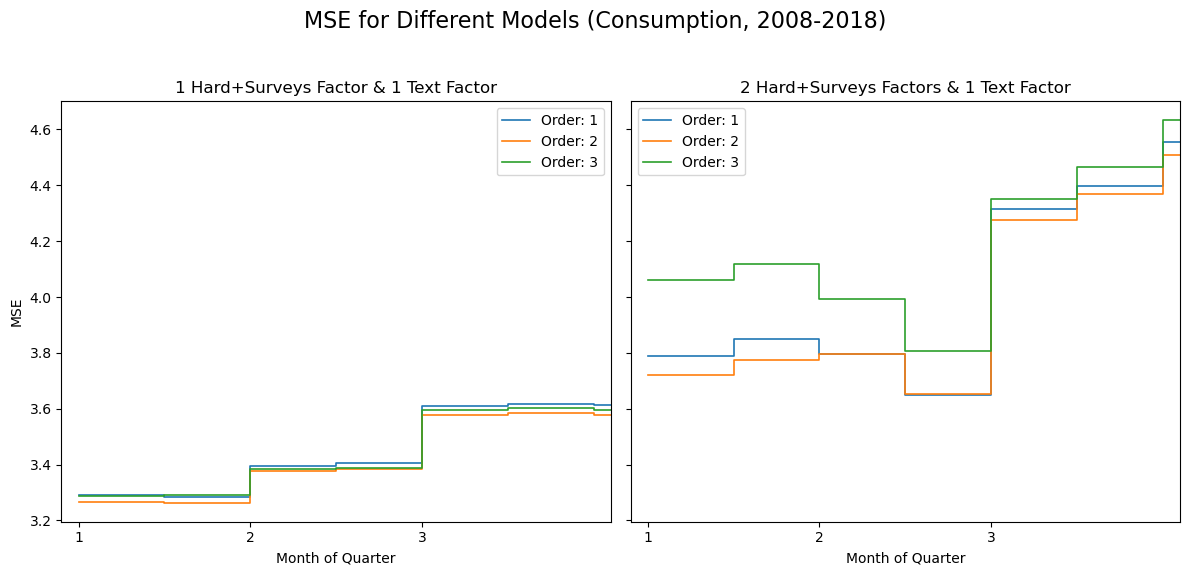

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


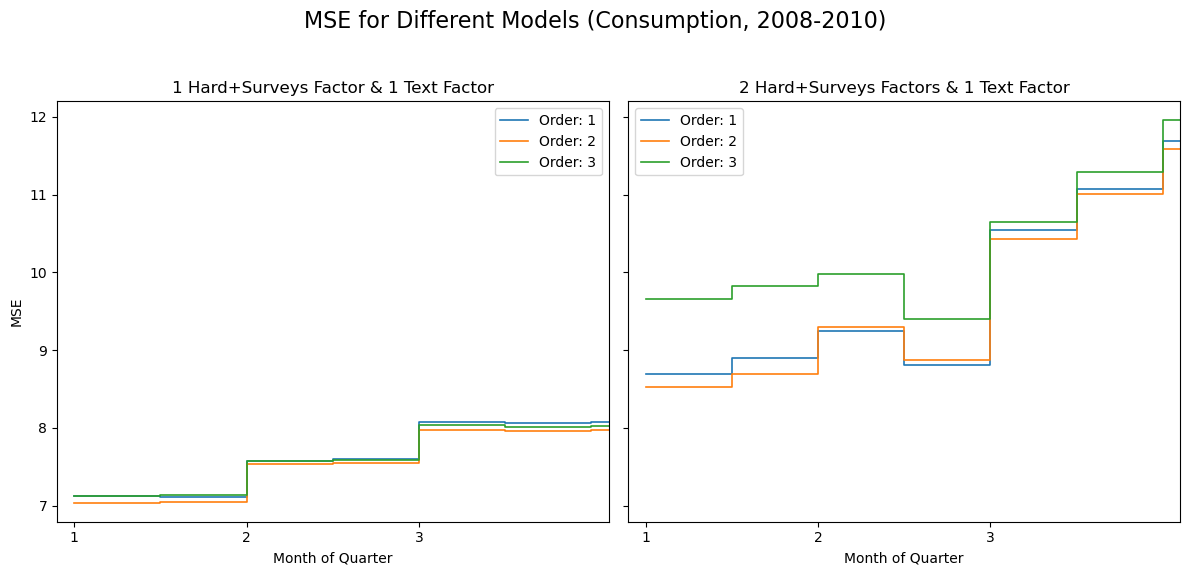

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


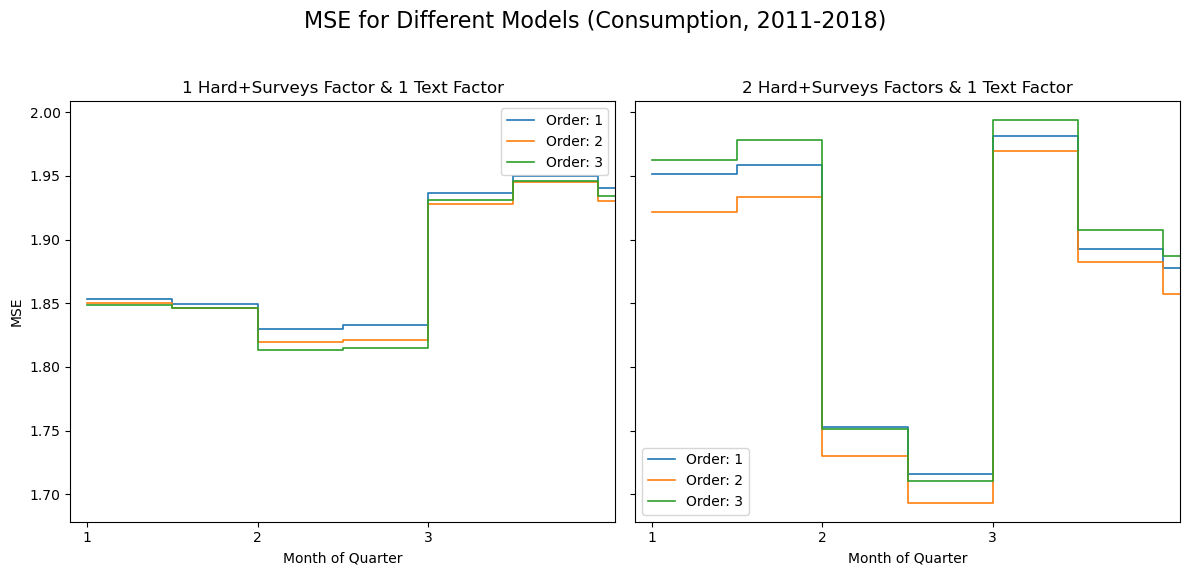

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


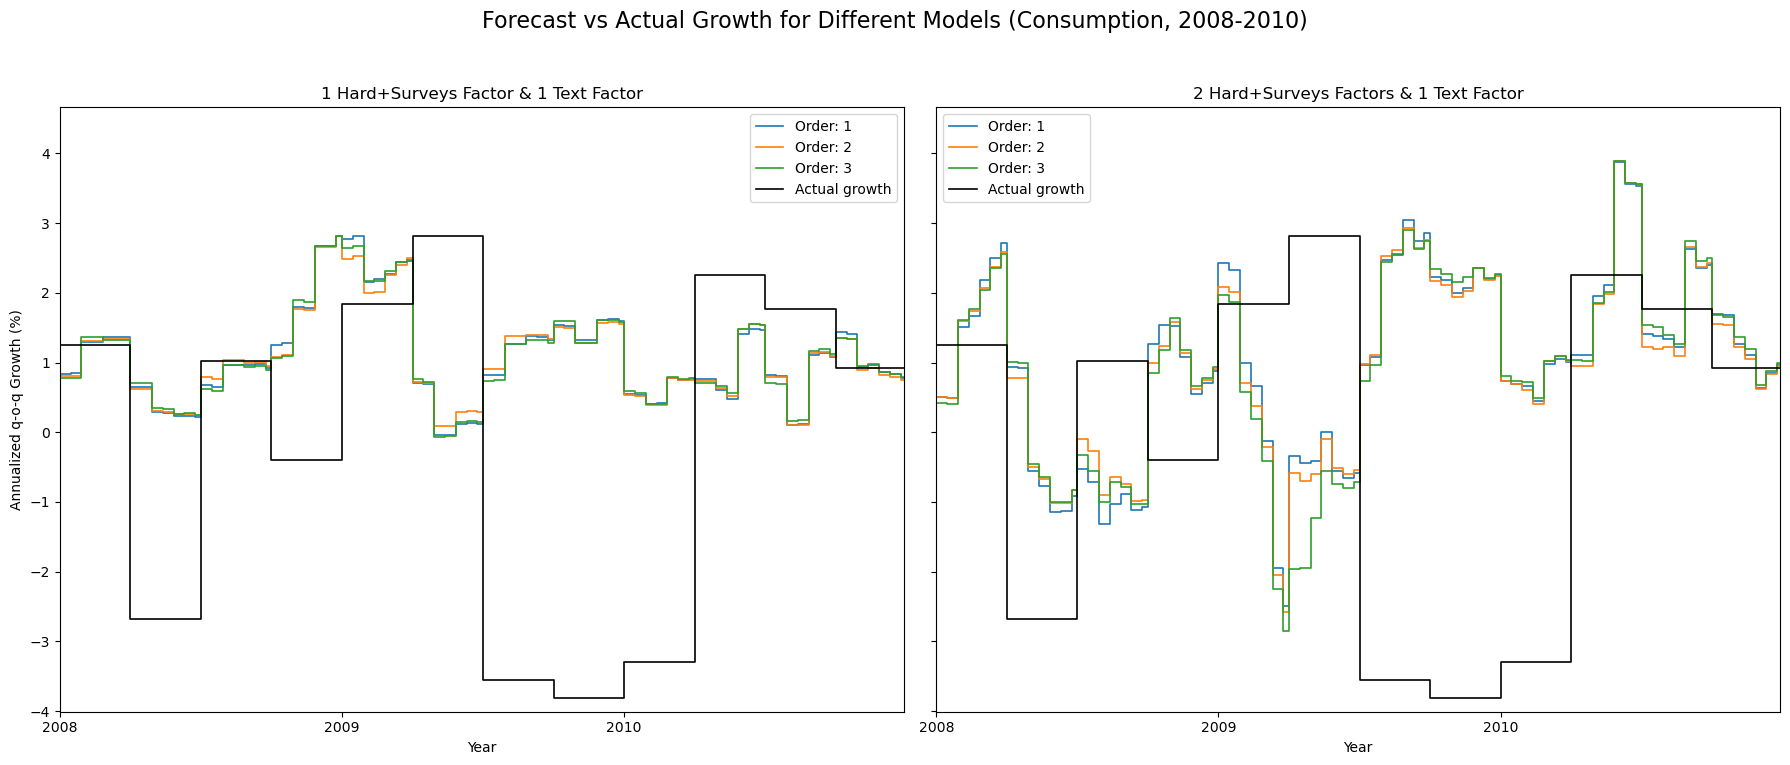

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


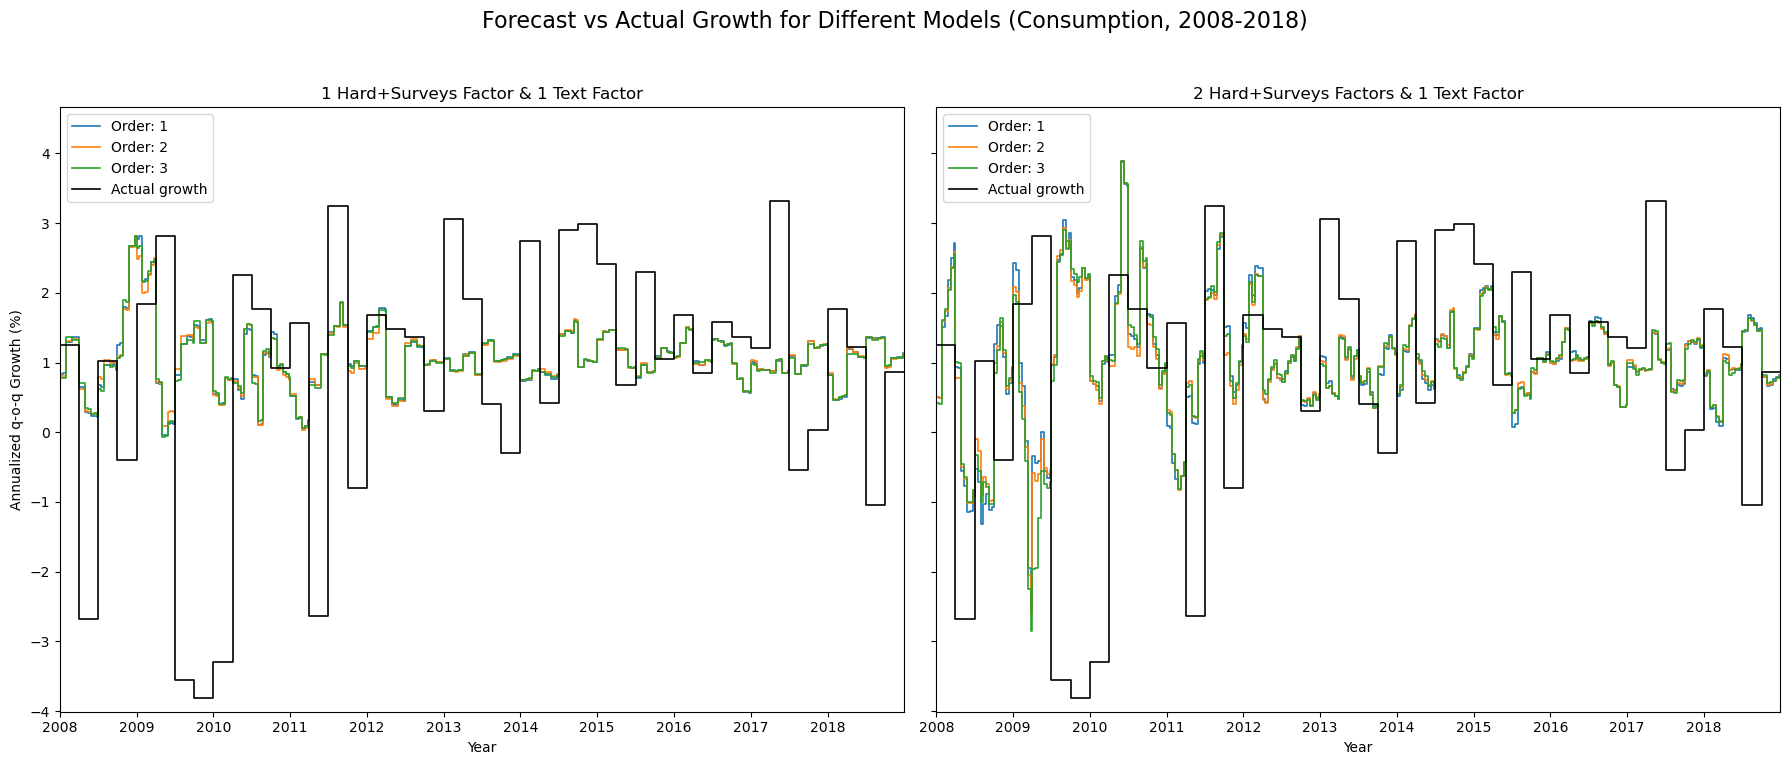

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


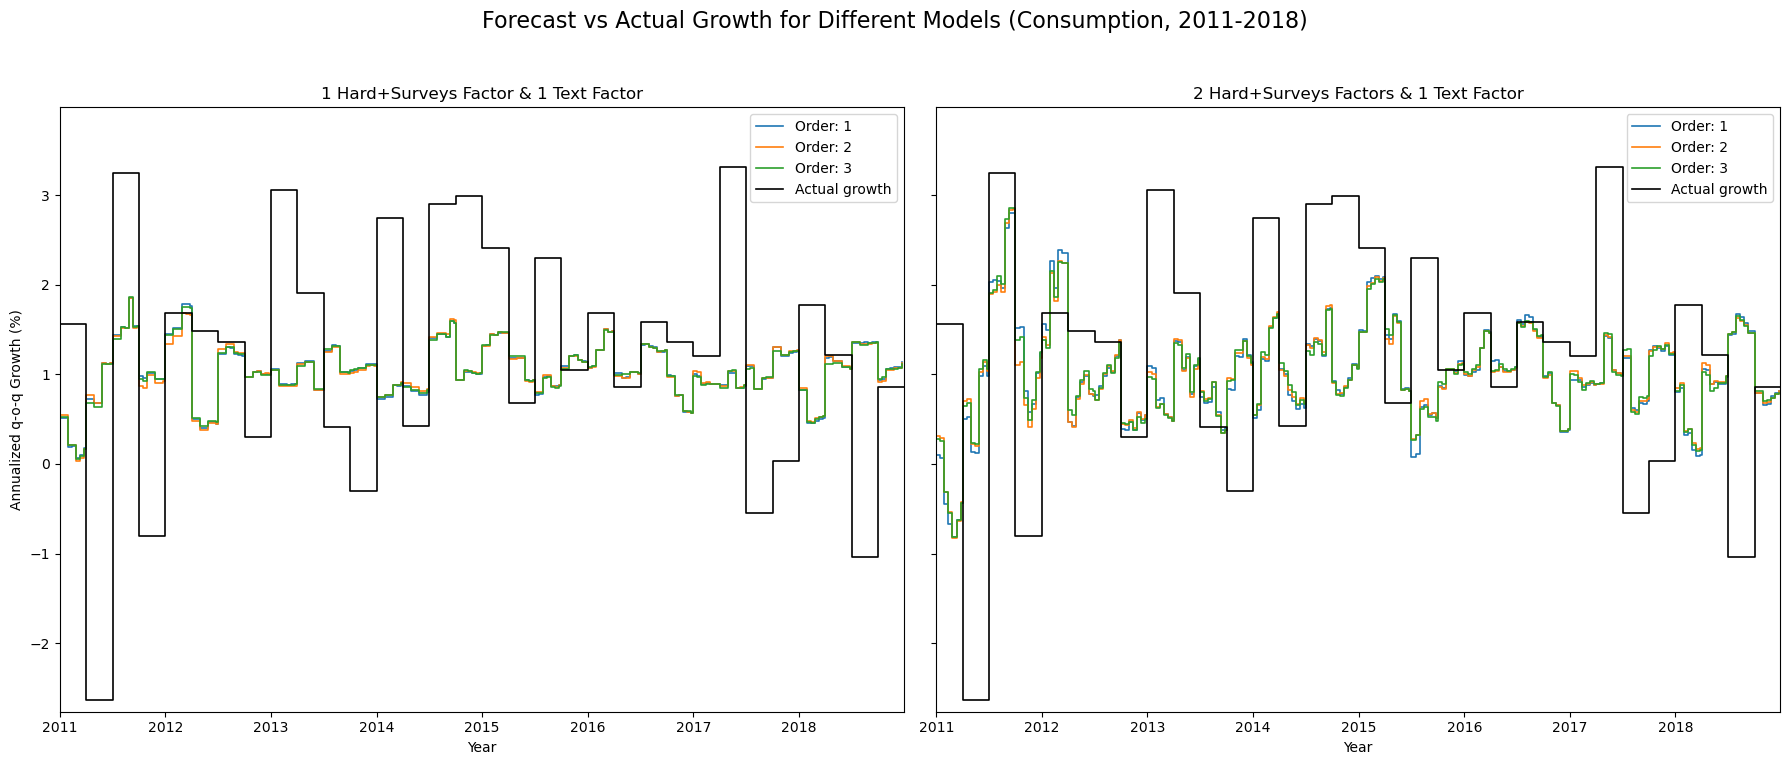

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()